In [67]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import seaborn as sns
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

state = 1
np.random.seed(1)


DATA_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/data/'
ROOT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/'
GROUND_PATH = DATA_PATH + '/groundTruth/'
ORI_IMAGE_PATH = DATA_PATH + '/images/'
OUT_IMAGE_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/image/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/model/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/result/'
LOG_PATH = '/media/tulan/Linux/Pycharm/Image_Edge/logs/'


def save_fig(fig_id, tight_layout=True):
    if not os.path.exists(OUT_IMAGE_PATH):
        os.makedirs(OUT_IMAGE_PATH)
    path = os.path.join(OUT_IMAGE_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test_ori.npy')
X_val = np.load(DATA_PATH + 'X_val_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_concat.npy')
y_test = np.load(DATA_PATH + 'y_test_concat.npy')
y_val = np.load(DATA_PATH + 'y_val_concat.npy')
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((200, 320, 480, 3),
 (200, 320, 480, 3),
 (100, 320, 480, 3),
 (200, 320, 480, 1),
 (200, 320, 480, 1),
 (100, 320, 480, 1))

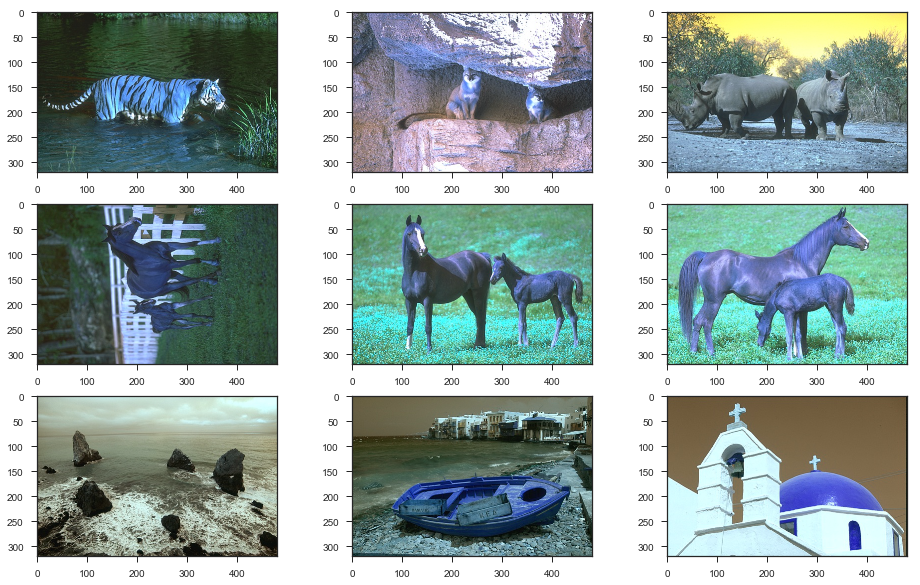

In [3]:
# Visualize training set
plt.figure(figsize=(16, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i+10])
plt.show()

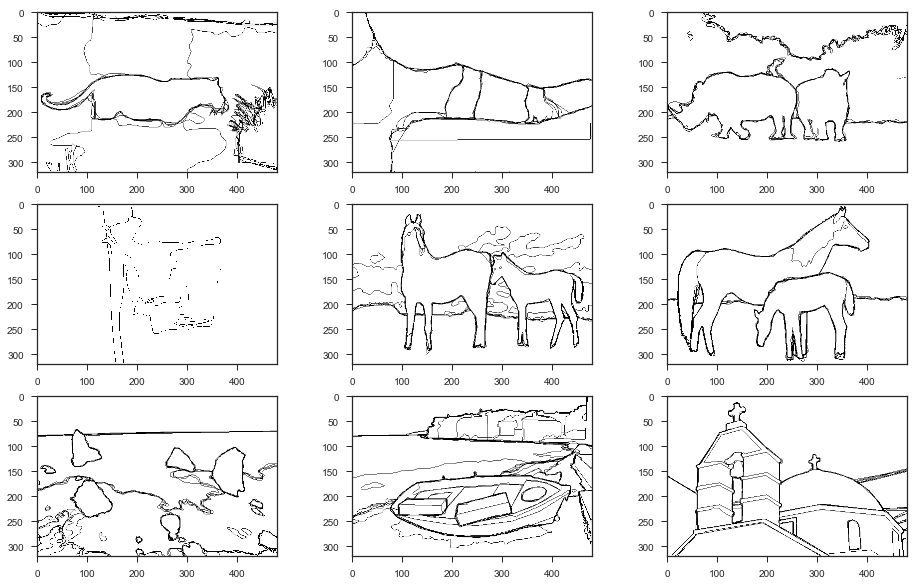

In [4]:
# Visualize Ground Truth Labels
plt.figure(figsize=(16, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(y_train[i+10].reshape((320,480)), cmap='binary')
plt.show()

In [102]:
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, add, Activation, Input, \
                            Lambda, MaxPooling2D, Concatenate
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.initializers import he_normal, glorot_normal
from keras import backend as K

import tensorflow as tf

In [37]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=-1, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=-1, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=-1, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [78]:
def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x


def cross_entropy_balanced(y_true, y_pred):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    Compute edge pixels for each training sample and set as pos_weights to tf.nn.weighted_cross_entropy_with_logits
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    # Equation [2]
    beta = count_neg / (count_neg + count_pos)

    # Equation [2] divide by 1 - beta
    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # Multiply by 1 - beta
    cost = tf.reduce_mean(cost * (1 - beta))

    # check if image has no edge pixels return 0 else return complete error function
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)

def ofuse_pixel_error(y_true, y_pred):
    pred = tf.cast(tf.greater(y_pred, 0.5), tf.int32, name='predictions')
    error = tf.cast(tf.not_equal(pred, tf.cast(y_true, tf.int32)), tf.float32)
    return tf.reduce_mean(error, name='pixel_error')

In [59]:
def ResNet_Tu(input_shape = None):
    input_img = Input(shape=input_shape, name='input')
    x = Lambda(lambda x: x/255, name='pre-process')(input_img)
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='conv1')(x)
    x = BatchNormalization(axis=-1, name='bn_conv1')(x)
    x = Activation('relu', name='act1')(x)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='maxpool1')(x)
    
    x = conv_block(x, 3, (32, 32, 128), stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, (32, 32, 128), stage=2, block='b')
    x = identity_block(x, 3, (32, 32, 128), stage=2, block='c')
    
    x = conv_block(x, 3, (64, 64, 256), stage=3, block='a', strides=(2, 2))
    x = identity_block(x, 3, (64, 64, 256), stage=3, block='b')
    x = identity_block(x, 3, (64, 64, 256), stage=3, block='c')
    
    x = Conv2D(1, (1, 1), strides=(1, 1), padding='same', name='convOut')(x)
    x = Conv2DTranspose(1, (8, 8), strides=(8, 8), padding='same', name='upsample')(x)
    x = Activation('sigmoid', name='act_out')(x)
    
    model = Model(inputs=input_img, outputs=x, name='ResNet_Tu')
       
    return model

In [74]:
model = ResNet_Tu(input_shape=(320, 480, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
pre-process (Lambda)            (None, 320, 480, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 240, 64) 4864        pre-process[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 240, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Acti

In [75]:
def schedule(epoch):
    init_lr = 1e-5
    power = int(epoch / 100)
    factor = 0.5
    lr = init_lr * factor ** power
    return lr


# lr_decay = LearningRateScheduler(schedule=schedule)    
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1, min_lr=1e-7)
checkpointer = ModelCheckpoint('model_ResNet_Tu_v1.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH, write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

optimizer = SGD(lr=1e-2, momentum=0.9, decay=2e-4, nesterov=False)

model = ResNet_Tu(input_shape=(320, 480, 3))
model.compile(optimizer=optimizer, loss=cross_entropy_balanced)

results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=200, 
                    callbacks=callback_list, verbose=2)

Train on 200 samples, validate on 100 samples


Epoch 1/200


Epoch 00001: val_loss improved from inf to 0.07500, saving model to model_ResNet_Tu_v1.h5


 - 14s - loss: 0.1719 - val_loss: 0.0750


Epoch 2/200


Epoch 00002: val_loss improved from 0.07500 to 0.06954, saving model to model_ResNet_Tu_v1.h5
 - 5s - loss: 0.0876 - val_loss: 0.0695


Epoch 3/200


Epoch 00003: val_loss improved from 0.06954 to 0.06798, saving model to model_ResNet_Tu_v1.h5
 - 5s - loss: 0.0685 - val_loss: 0.0680


Epoch 4/200


Epoch 00004: val_loss improved from 0.06798 to 0.06796, saving model to model_ResNet_Tu_v1.h5
 - 5s - loss: 0.0661 - val_loss: 0.0680


Epoch 5/200


Epoch 00005: val_loss improved from 0.06796 to 0.06793, saving model to model_ResNet_Tu_v1.h5
 - 5s - loss: 0.0651 - val_loss: 0.0679


Epoch 6/200


Epoch 00006: val_loss did not improve
 - 5s - loss: 0.0646 - val_loss: 0.0679


Epoch 7/200


Epoch 00007: val_loss did not improve
 - 5s - loss: 0.0644 - val_loss: 0.0679


Epoch 8/200


Epoch 00008: val_loss did not improve
 - 5s - loss: 0.0642 - val_loss: 0.0680


Epoch 9/200


Epoch 00009: val_loss did not improve
 - 5s - loss: 0.0641 - val_loss: 0.0680


Epoch 10/200


Epoch 00010: val_loss did not improve
 - 5s - loss: 0.0639 - val_loss: 0.0680


Epoch 11/200


Epoch 00011: val_loss did not improve
 - 5s - loss: 0.0638 - val_loss: 0.0680


Epoch 12/200


Epoch 00012: val_loss did not improve
 - 5s - loss: 0.0638 - val_loss: 0.0680


Epoch 13/200


Epoch 00013: val_loss did not improve
 - 5s - loss: 0.0636 - val_loss: 0.0681


Epoch 14/200


Epoch 00014: val_loss did not improve
 - 5s - loss: 0.0636 - val_loss: 0.0681


Epoch 15/200


Epoch 00015: val_loss did not improve
 - 5s - loss: 0.0636 - val_loss: 0.0681


Epoch 16/200


Epoch 00016: val_loss did not improve
 - 5s - loss: 0.0635 - val_loss: 0.0681


Epoch 17/200


Epoch 00017: val_loss did not improve
 - 5s - loss: 0.0635 - val_loss: 0.0681


Epoch 18/200


Epoch 00018: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0682


Epoch 19/200


Epoch 00019: val_loss did not improve
 - 5s - loss: 0.0635 - val_loss: 0.0682


Epoch 20/200


Epoch 00020: val_loss did not improve
 - 5s - loss: 0.0635 - val_loss: 0.0682


Epoch 21/200


Epoch 00021: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0683


Epoch 22/200


Epoch 00022: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0683


Epoch 23/200


Epoch 00023: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0683


Epoch 24/200


Epoch 00024: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0683


Epoch 25/200


Epoch 00025: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0683


Epoch 26/200


Epoch 00026: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 27/200


Epoch 00027: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0689


Epoch 28/200


Epoch 00028: val_loss did not improve
 - 5s - loss: 0.0634 - val_loss: 0.0685


Epoch 29/200


Epoch 00029: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0685


Epoch 30/200


Epoch 00030: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 31/200


Epoch 00031: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 32/200



Epoch 00032: reducing learning rate to 0.0019999999552965165.
Epoch 00032: val_loss did not improve
 - 6s - loss: 0.0632 - val_loss: 0.0684


Epoch 33/200


Epoch 00033: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 34/200


Epoch 00034: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 35/200


Epoch 00035: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 36/200


Epoch 00036: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 37/200



Epoch 00037: reducing learning rate to 0.0003999999724328518.
Epoch 00037: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 38/200


Epoch 00038: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 39/200


Epoch 00039: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 40/200


Epoch 00040: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 41/200


Epoch 00041: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 42/200



Epoch 00042: reducing learning rate to 7.999999215826393e-05.
Epoch 00042: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 43/200


Epoch 00043: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 44/200


Epoch 00044: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 45/200


Epoch 00045: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 46/200


Epoch 00046: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 47/200


Epoch 00047: val_loss did not improve
 - 5s - loss: 0.0633 - val_loss: 0.0684


Epoch 48/200


Epoch 00048: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 49/200


Epoch 00049: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 50/200



Epoch 00050: reducing learning rate to 1.599999814061448e-05.
Epoch 00050: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 51/200


Epoch 00051: val_loss did not improve
 - 5s - loss: 0.0632 - val_loss: 0.0684


Epoch 52/200


KeyboardInterrupt: 

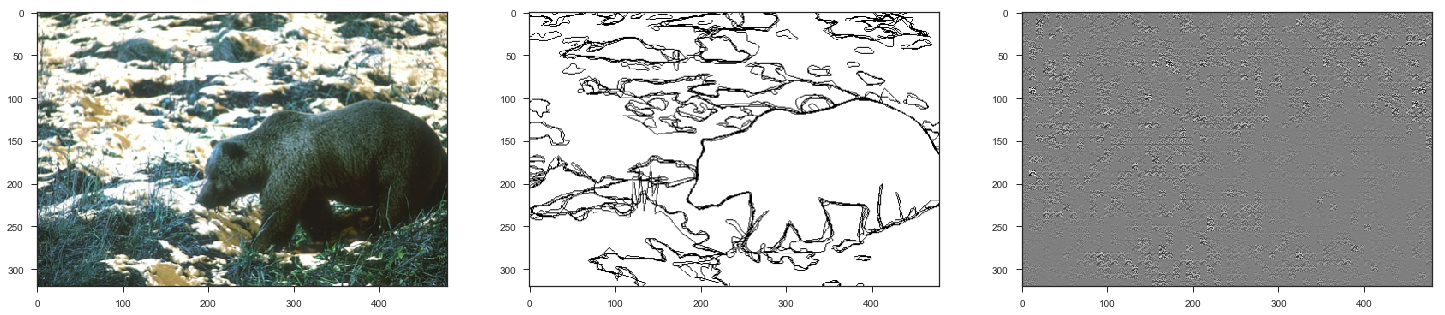

In [77]:
y_pred_1 = model.predict(X_train[2].reshape((-1,320,480,3)))
y_pred_1 = y_pred_1.reshape((320, 480))
np.savetxt(RESULT_PATH + '/sample_pred.csv', y_pred_1, fmt='%3f')

plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[2], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[2].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred_1, cmap='binary')
plt.show()

In [117]:
def side_branch(x, factor):
    x = Conv2D(1, (1, 1), activation=None, padding='same')(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(1, kernel_size, strides=factor, padding='same', 
                        use_bias=False, activation=None, kernel_initializer=init)(x)
    return x

init = glorot_normal(seed=1)

def hed():
    # Input
    img_input = Input(shape=(320,480,3), name='input')
    x = Lambda(lambda x: x/255)(img_input)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_initializer=init)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_initializer=init)(x)
    b1= side_branch(x, 1) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x) # 240 240 64

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_initializer=init)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_initializer=init)(x)
    b2= side_branch(x, 2) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool')(x) # 120 120 128

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_initializer=init)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_initializer=init)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_initializer=init)(x)
    b3= side_branch(x, 4) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool')(x) # 60 60 256

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_initializer=init)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_initializer=init)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_initializer=init)(x)
    b4= side_branch(x, 8) # 480 480 1
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block4_pool')(x) # 30 30 512

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_initializer=init)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_initializer=init)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_initializer=init)(x) # 30 30 512
    b5= side_branch(x, 16) # 480 480 1

    # fuse
    fuse = Concatenate(axis=-1)([b1, b2, b3, b4, b5])
    fuse = Conv2D(1, (1,1), padding='same', use_bias=False, activation=None, kernel_initializer=init)(fuse) # 480 480 1

    # outputs
    o1    = Activation('sigmoid', name='o1')(b1)
    o2    = Activation('sigmoid', name='o2')(b2)
    o3    = Activation('sigmoid', name='o3')(b3)
    o4    = Activation('sigmoid', name='o4')(b4)
    o5    = Activation('sigmoid', name='o5')(b5)
    ofuse = Activation('sigmoid', name='ofuse')(fuse)


    # model
    model = Model(inputs=[img_input], outputs=[o1, o2, o3, o4, o5, ofuse])
    # filepath = '/home/congliu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    # load_weights_from_hdf5_group_by_name(model, filepath)

    model.compile(loss={'o1': cross_entropy_balanced,
                        'o2': cross_entropy_balanced,
                        'o3': cross_entropy_balanced,
                        'o4': cross_entropy_balanced,
                        'o5': cross_entropy_balanced,
                        'ofuse': cross_entropy_balanced,
                        },
                  metrics={'ofuse': ofuse_pixel_error},
                  optimizer=optimizer2)

    return model

In [112]:
model2 = hed()
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 320, 480, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 480, 64) 1792        lambda_6[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_poo

In [118]:
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-7)
checkpointer = ModelCheckpoint('model_HED_Tu_v1.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH, write_graph=True)
early_stop = EarlyStopping(monitor='train_loss', min_delta=0, patience=20, verbose=1)
callback_list = [lr_decay, checkpointer, tensorbord, early_stop]

optimizer = SGD(lr=1e-5, momentum=0.9, decay=2e-4, nesterov=False)
optimizer2 = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, decay=2e-4,)

model2 = hed()

results = model2.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                     validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                     batch_size=10, epochs=1000, callbacks=callback_list, verbose=2)

Train on 200 samples, validate on 100 samples


Epoch 1/1000


Epoch 00001: val_loss improved from inf to 0.40716, saving model to model_HED_Tu_v1.h5


 - 26s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8520 - val_loss: 0.4072 - val_o1_loss: 0.0679 - val_o2_loss: 0.0679 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8364


/home/tulan/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:493: RuntimeWarning: Early stopping conditioned on metric `train_loss` which is not available. Available metrics are: val_loss,val_o1_loss,val_o2_loss,val_o3_loss,val_o4_loss,val_o5_loss,val_ofuse_loss,val_ofuse_ofuse_pixel_error,loss,o1_loss,o2_loss,o3_loss,o4_loss,o5_loss,ofuse_loss,ofuse_ofuse_pixel_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/1000


Epoch 00002: val_loss improved from 0.40716 to 0.40716, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8494 - val_loss: 0.4072 - val_o1_loss: 0.0679 - val_o2_loss: 0.0679 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8328


Epoch 3/1000


Epoch 00003: val_loss improved from 0.40716 to 0.40716, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8443 - val_loss: 0.4072 - val_o1_loss: 0.0679 - val_o2_loss: 0.0679 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8259


Epoch 4/1000


Epoch 00004: val_loss improved from 0.40716 to 0.40716, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8406 - val_loss: 0.4072 - val_o1_loss: 0.0679 - val_o2_loss: 0.0679 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8219


Epoch 5/1000


Epoch 00005: val_loss improved from 0.40716 to 0.40715, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8323 - val_loss: 0.4072 - val_o1_loss: 0.0679 - val_o2_loss: 0.0679 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8117


Epoch 6/1000


Epoch 00006: val_loss improved from 0.40715 to 0.40715, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8283 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8093


Epoch 7/1000



Epoch 00007: reducing learning rate to 1.9999999949504855e-07.
Epoch 00007: val_loss improved from 0.40715 to 0.40715, saving model to model_HED_Tu_v1.h5


 - 20s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8231 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8060


Epoch 8/1000


Epoch 00008: val_loss improved from 0.40715 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8229 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8065


Epoch 9/1000


Epoch 00009: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8225 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8058


Epoch 10/1000


Epoch 00010: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8216 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8051


Epoch 11/1000


Epoch 00011: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8211 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8044


Epoch 12/1000



Epoch 00012: reducing learning rate to 1e-07.
Epoch 00012: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8203 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8039


Epoch 13/1000


Epoch 00013: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8198 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8036


Epoch 14/1000


Epoch 00014: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8196 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8034


Epoch 15/1000


Epoch 00015: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8193 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8031


Epoch 16/1000


Epoch 00016: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8192 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8030


Epoch 17/1000


Epoch 00017: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8189 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8028


Epoch 18/1000


Epoch 00018: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8188 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8029


Epoch 19/1000


Epoch 00019: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8188 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8028


Epoch 20/1000


Epoch 00020: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8187 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8027


Epoch 21/1000


Epoch 00021: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8181 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8020


Epoch 22/1000


Epoch 00022: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8178 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8019


Epoch 23/1000


Epoch 00023: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8176 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8019


Epoch 24/1000


Epoch 00024: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8173 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8015


Epoch 25/1000


Epoch 00025: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8172 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8016


Epoch 26/1000


Epoch 00026: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8172 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8017


Epoch 27/1000


Epoch 00027: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8169 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8012


Epoch 28/1000


Epoch 00028: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8166 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8013


Epoch 29/1000


Epoch 00029: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8166 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8012


Epoch 30/1000


Epoch 00030: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8164 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8009


Epoch 31/1000


Epoch 00031: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8162 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8008


Epoch 32/1000


Epoch 00032: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8163 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8010


Epoch 33/1000


Epoch 00033: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8160 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8005


Epoch 34/1000


Epoch 00034: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8159 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8007


Epoch 35/1000


Epoch 00035: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8157 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8002


Epoch 36/1000


Epoch 00036: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8153 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8002


Epoch 37/1000


Epoch 00037: val_loss improved from 0.40714 to 0.40714, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8152 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.7998


Epoch 38/1000


Epoch 00038: val_loss improved from 0.40714 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8151 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.8002


Epoch 39/1000


Epoch 00039: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8149 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0679 - val_ofuse_ofuse_pixel_error: 0.7996


Epoch 40/1000


Epoch 00040: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8147 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7995


Epoch 41/1000


Epoch 00041: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8144 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7993


Epoch 42/1000


Epoch 00042: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8145 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7996


Epoch 43/1000


Epoch 00043: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8143 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7993


Epoch 44/1000


Epoch 00044: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8141 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7986


Epoch 45/1000


Epoch 00045: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8139 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7984


Epoch 46/1000


Epoch 00046: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8139 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7984


Epoch 47/1000


Epoch 00047: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8136 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7978


Epoch 48/1000


Epoch 00048: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8131 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7971


Epoch 49/1000


Epoch 00049: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8129 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7972


Epoch 50/1000


Epoch 00050: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8128 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7970


Epoch 51/1000


Epoch 00051: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8124 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7962


Epoch 52/1000


Epoch 00052: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8123 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7964


Epoch 53/1000


Epoch 00053: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8121 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7961


Epoch 54/1000


Epoch 00054: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8118 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7956


Epoch 55/1000


Epoch 00055: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8116 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7958


Epoch 56/1000


Epoch 00056: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8117 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7958


Epoch 57/1000


Epoch 00057: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8116 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7954


Epoch 58/1000


Epoch 00058: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8110 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7950


Epoch 59/1000


Epoch 00059: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8105 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7945


Epoch 60/1000


Epoch 00060: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8103 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7943


Epoch 61/1000


Epoch 00061: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8098 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7938


Epoch 62/1000


Epoch 00062: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8096 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7936


Epoch 63/1000


Epoch 00063: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8091 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7934


Epoch 64/1000


Epoch 00064: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8093 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7937


Epoch 65/1000


Epoch 00065: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8091 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7932


Epoch 66/1000


Epoch 00066: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8087 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7929


Epoch 67/1000


Epoch 00067: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8084 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7927


Epoch 68/1000


Epoch 00068: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8082 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7925


Epoch 69/1000


Epoch 00069: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8080 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7924


Epoch 70/1000


Epoch 00070: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8076 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7920


Epoch 71/1000


Epoch 00071: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8075 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7920


Epoch 72/1000


Epoch 00072: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8076 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7921


Epoch 73/1000


Epoch 00073: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8076 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7921


Epoch 74/1000


Epoch 00074: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8070 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7914


Epoch 75/1000


Epoch 00075: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8069 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7916


Epoch 76/1000


Epoch 00076: val_loss improved from 0.40713 to 0.40713, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8066 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7913


Epoch 77/1000


Epoch 00077: val_loss improved from 0.40713 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8064 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7911


Epoch 78/1000


Epoch 00078: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8063 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7911


Epoch 79/1000


Epoch 00079: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8063 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7911


Epoch 80/1000


Epoch 00080: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8064 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7913


Epoch 81/1000


Epoch 00081: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8064 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7914


Epoch 82/1000


Epoch 00082: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8063 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7912


Epoch 83/1000


Epoch 00083: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8063 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7911


Epoch 84/1000


Epoch 00084: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8061 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7912


Epoch 85/1000


Epoch 00085: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8060 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7910


Epoch 86/1000


Epoch 00086: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8059 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7908


Epoch 87/1000


Epoch 00087: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8057 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7907


Epoch 88/1000


Epoch 00088: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8055 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7906


Epoch 89/1000


Epoch 00089: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8053 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7906


Epoch 90/1000


Epoch 00090: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8053 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7903


Epoch 91/1000


Epoch 00091: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8048 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7900


Epoch 92/1000


Epoch 00092: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8048 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7903


Epoch 93/1000


Epoch 00093: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8048 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7902


Epoch 94/1000


Epoch 00094: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8049 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7904


Epoch 95/1000


Epoch 00095: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8051 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7906


Epoch 96/1000


Epoch 00096: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8051 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7905


Epoch 97/1000


Epoch 00097: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8053 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7909


Epoch 98/1000


Epoch 00098: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8054 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7907


Epoch 99/1000


Epoch 00099: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8052 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7906


Epoch 100/1000


Epoch 00100: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8050 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7905


Epoch 101/1000


Epoch 00101: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8050 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7905


Epoch 102/1000


Epoch 00102: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8050 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7905


Epoch 103/1000


Epoch 00103: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8049 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7905


Epoch 104/1000


Epoch 00104: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8048 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7904


Epoch 105/1000


Epoch 00105: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8048 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7905


Epoch 106/1000


Epoch 00106: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8046 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7900


Epoch 107/1000


Epoch 00107: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8040 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7896


Epoch 108/1000


Epoch 00108: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8039 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7897


Epoch 109/1000


Epoch 00109: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8041 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7899


Epoch 110/1000


Epoch 00110: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8039 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7896


Epoch 111/1000


Epoch 00111: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8038 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7897


Epoch 112/1000


Epoch 00112: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8039 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7898


Epoch 113/1000


Epoch 00113: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8039 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7898


Epoch 114/1000


Epoch 00114: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8040 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7900


Epoch 115/1000


Epoch 00115: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8039 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7896


Epoch 116/1000


Epoch 00116: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8037 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7898


Epoch 117/1000


Epoch 00117: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8037 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7896


Epoch 118/1000


Epoch 00118: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8035 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7896


Epoch 119/1000


Epoch 00119: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8034 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7895


Epoch 120/1000


Epoch 00120: val_loss improved from 0.40712 to 0.40712, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8036 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7896


Epoch 121/1000


Epoch 00121: val_loss improved from 0.40712 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8034 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7895


Epoch 122/1000


Epoch 00122: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8033 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7894


Epoch 123/1000


Epoch 00123: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8033 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7895


Epoch 124/1000


Epoch 00124: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8031 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7891


Epoch 125/1000


Epoch 00125: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8030 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7892


Epoch 126/1000


Epoch 00126: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8028 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7889


Epoch 127/1000


Epoch 00127: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8025 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7888


Epoch 128/1000


Epoch 00128: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8024 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7887


Epoch 129/1000


Epoch 00129: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8026 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7889


Epoch 130/1000


Epoch 00130: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8024 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7887


Epoch 131/1000


Epoch 00131: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8025 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7890


Epoch 132/1000


Epoch 00132: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8027 - val_loss: 0.4071 - val_o1_loss: 0.0679 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7890


Epoch 133/1000


Epoch 00133: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8023 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7887


Epoch 134/1000


Epoch 00134: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8022 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7886


Epoch 135/1000


Epoch 00135: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8019 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7883


Epoch 136/1000


Epoch 00136: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8019 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7885


Epoch 137/1000


Epoch 00137: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8020 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7886


Epoch 138/1000


Epoch 00138: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8019 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7885


Epoch 139/1000


Epoch 00139: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8021 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7888


Epoch 140/1000


Epoch 00140: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8024 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7891


Epoch 141/1000


Epoch 00141: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8025 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7891


Epoch 142/1000


Epoch 00142: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8024 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7890


Epoch 143/1000


Epoch 00143: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8024 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7892


Epoch 144/1000


Epoch 00144: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8025 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7891


Epoch 145/1000


Epoch 00145: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8024 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7891


Epoch 146/1000


Epoch 00146: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8021 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7888


Epoch 147/1000


Epoch 00147: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8019 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7886


Epoch 148/1000


Epoch 00148: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8018 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7887


Epoch 149/1000


Epoch 00149: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8019 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7887


Epoch 150/1000


Epoch 00150: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8019 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7888


Epoch 151/1000


Epoch 00151: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8017 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7885


Epoch 152/1000


Epoch 00152: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8015 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7883


Epoch 153/1000


Epoch 00153: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8015 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7883


Epoch 154/1000


Epoch 00154: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8014 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7883


Epoch 155/1000


Epoch 00155: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8011 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7878


Epoch 156/1000


Epoch 00156: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8008 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7877


Epoch 157/1000


Epoch 00157: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8006 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7876


Epoch 158/1000


Epoch 00158: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8006 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7875


Epoch 159/1000


Epoch 00159: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8005 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7874


Epoch 160/1000


Epoch 00160: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8003 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7874


Epoch 161/1000


Epoch 00161: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8005 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7876


Epoch 162/1000


Epoch 00162: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8004 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7873


Epoch 163/1000


Epoch 00163: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8003 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7874


Epoch 164/1000


Epoch 00164: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8002 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7872


Epoch 165/1000


Epoch 00165: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8001 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7872


Epoch 166/1000


Epoch 00166: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8003 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7874


Epoch 167/1000


Epoch 00167: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.8001 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7871


Epoch 168/1000


Epoch 00168: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8000 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7872


Epoch 169/1000


Epoch 00169: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.8001 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7871


Epoch 170/1000


Epoch 00170: val_loss improved from 0.40711 to 0.40711, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7999 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7869


Epoch 171/1000


Epoch 00171: val_loss improved from 0.40711 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7998 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7868


Epoch 172/1000


Epoch 00172: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7995 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 173/1000


Epoch 00173: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7992 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 174/1000


Epoch 00174: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7992 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 175/1000


Epoch 00175: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7993 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 176/1000


Epoch 00176: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 177/1000


Epoch 00177: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 178/1000


Epoch 00178: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7991 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 179/1000


Epoch 00179: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7992 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 180/1000


Epoch 00180: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 181/1000


Epoch 00181: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7992 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 182/1000


Epoch 00182: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7991 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 183/1000


Epoch 00183: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 184/1000


Epoch 00184: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 185/1000


Epoch 00185: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7991 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 186/1000


Epoch 00186: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 187/1000


Epoch 00187: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7991 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 188/1000


Epoch 00188: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7989 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 189/1000


Epoch 00189: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7988 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 190/1000


Epoch 00190: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7988 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 191/1000


Epoch 00191: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7989 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 192/1000


Epoch 00192: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7989 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 193/1000


Epoch 00193: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7988 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 194/1000


Epoch 00194: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7988 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 195/1000


Epoch 00195: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7990 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 196/1000


Epoch 00196: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7989 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 197/1000


Epoch 00197: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7989 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 198/1000


Epoch 00198: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7989 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 199/1000


Epoch 00199: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7987 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 200/1000


Epoch 00200: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7987 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 201/1000


Epoch 00201: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7988 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 202/1000


Epoch 00202: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7986 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 203/1000


Epoch 00203: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7985 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 204/1000


Epoch 00204: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7984 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 205/1000


Epoch 00205: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7987 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 206/1000


Epoch 00206: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7987 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 207/1000


Epoch 00207: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7987 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 208/1000


Epoch 00208: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7987 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 209/1000


Epoch 00209: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7985 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 210/1000


Epoch 00210: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3770 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7985 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 211/1000


Epoch 00211: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7984 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 212/1000


Epoch 00212: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7984 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 213/1000


Epoch 00213: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7983 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7856


Epoch 214/1000


Epoch 00214: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7982 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 215/1000


Epoch 00215: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7983 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 216/1000


Epoch 00216: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7983 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 217/1000


Epoch 00217: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7983 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 218/1000


Epoch 00218: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7983 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 219/1000


Epoch 00219: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7982 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 220/1000


Epoch 00220: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7981 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 221/1000


Epoch 00221: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7982 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 222/1000


Epoch 00222: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7981 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 223/1000


Epoch 00223: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7981 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 224/1000


Epoch 00224: val_loss improved from 0.40710 to 0.40710, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7979 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 225/1000


Epoch 00225: val_loss improved from 0.40710 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3757 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0626 - o5_loss: 0.0626 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7977 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 226/1000


Epoch 00226: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7976 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 227/1000


Epoch 00227: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7976 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 228/1000


Epoch 00228: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7978 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 229/1000


Epoch 00229: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7978 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 230/1000


Epoch 00230: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7977 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 231/1000


Epoch 00231: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7978 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 232/1000


Epoch 00232: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7978 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 233/1000


Epoch 00233: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7975 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 234/1000


Epoch 00234: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7975 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 235/1000


Epoch 00235: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7975 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 236/1000


Epoch 00236: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7975 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 237/1000


Epoch 00237: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7975 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 238/1000


Epoch 00238: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7974 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 239/1000


Epoch 00239: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7972 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 240/1000


Epoch 00240: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7971 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 241/1000


Epoch 00241: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7973 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 242/1000


Epoch 00242: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7973 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 243/1000


Epoch 00243: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7973 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 244/1000


Epoch 00244: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3757 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0626 - o5_loss: 0.0626 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7973 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 245/1000


Epoch 00245: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7974 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 246/1000


Epoch 00246: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7974 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 247/1000


Epoch 00247: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7973 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 248/1000


Epoch 00248: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7973 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 249/1000


Epoch 00249: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7972 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 250/1000


Epoch 00250: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7972 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 251/1000


Epoch 00251: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7971 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 252/1000


Epoch 00252: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 253/1000


Epoch 00253: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 254/1000


Epoch 00254: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7848


Epoch 255/1000


Epoch 00255: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 256/1000


Epoch 00256: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 257/1000


Epoch 00257: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 258/1000


Epoch 00258: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 259/1000


Epoch 00259: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 260/1000


Epoch 00260: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 261/1000


Epoch 00261: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 262/1000


Epoch 00262: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 263/1000


Epoch 00263: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 264/1000


Epoch 00264: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 265/1000


Epoch 00265: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 266/1000


Epoch 00266: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 267/1000


Epoch 00267: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 268/1000


Epoch 00268: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 269/1000


Epoch 00269: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 270/1000


Epoch 00270: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 271/1000


Epoch 00271: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 272/1000


Epoch 00272: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 273/1000


Epoch 00273: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 274/1000


Epoch 00274: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 275/1000


Epoch 00275: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 276/1000


Epoch 00276: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 277/1000


Epoch 00277: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 278/1000


Epoch 00278: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 279/1000


Epoch 00279: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 280/1000


Epoch 00280: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7856


Epoch 281/1000


Epoch 00281: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 282/1000


Epoch 00282: val_loss improved from 0.40709 to 0.40709, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 283/1000


Epoch 00283: val_loss improved from 0.40709 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 284/1000


Epoch 00284: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 285/1000


Epoch 00285: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7971 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 286/1000


Epoch 00286: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 287/1000


Epoch 00287: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 288/1000


Epoch 00288: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 289/1000


Epoch 00289: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 290/1000


Epoch 00290: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 291/1000


Epoch 00291: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7971 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 292/1000


Epoch 00292: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7971 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 293/1000


Epoch 00293: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7971 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 294/1000


Epoch 00294: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 295/1000


Epoch 00295: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 296/1000


Epoch 00296: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 297/1000


Epoch 00297: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 298/1000


Epoch 00298: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 299/1000


Epoch 00299: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 300/1000


Epoch 00300: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 301/1000


Epoch 00301: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7856


Epoch 302/1000


Epoch 00302: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7856


Epoch 303/1000


Epoch 00303: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 304/1000


Epoch 00304: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 305/1000


Epoch 00305: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 306/1000


Epoch 00306: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 307/1000


Epoch 00307: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7856


Epoch 308/1000


Epoch 00308: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 309/1000


Epoch 00309: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 310/1000


Epoch 00310: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 311/1000


Epoch 00311: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 312/1000


Epoch 00312: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 313/1000


Epoch 00313: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 314/1000


Epoch 00314: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 315/1000


Epoch 00315: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 316/1000


Epoch 00316: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 317/1000


Epoch 00317: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7970 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 318/1000


Epoch 00318: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7969 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 319/1000


Epoch 00319: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7968 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 320/1000


Epoch 00320: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 321/1000


Epoch 00321: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 322/1000


Epoch 00322: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 323/1000


Epoch 00323: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 324/1000


Epoch 00324: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 325/1000


Epoch 00325: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 326/1000


Epoch 00326: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 327/1000


Epoch 00327: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 328/1000


Epoch 00328: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 329/1000


Epoch 00329: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 330/1000


Epoch 00330: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 331/1000


Epoch 00331: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3770 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 332/1000


Epoch 00332: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7962 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 333/1000


Epoch 00333: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7962 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 334/1000


Epoch 00334: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 335/1000


Epoch 00335: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 336/1000


Epoch 00336: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 337/1000


Epoch 00337: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7962 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 338/1000


Epoch 00338: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7962 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 339/1000


Epoch 00339: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7962 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 340/1000


Epoch 00340: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 341/1000


Epoch 00341: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 342/1000


Epoch 00342: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 343/1000


Epoch 00343: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 344/1000


Epoch 00344: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 345/1000


Epoch 00345: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 346/1000


Epoch 00346: val_loss improved from 0.40708 to 0.40708, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 347/1000


Epoch 00347: val_loss improved from 0.40708 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 348/1000


Epoch 00348: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 349/1000


Epoch 00349: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 350/1000


Epoch 00350: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 351/1000


Epoch 00351: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7867


Epoch 352/1000


Epoch 00352: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7967 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7867


Epoch 353/1000


Epoch 00353: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7966 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 354/1000


Epoch 00354: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 355/1000


Epoch 00355: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 356/1000


Epoch 00356: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7965 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 357/1000


Epoch 00357: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 358/1000


Epoch 00358: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 359/1000


Epoch 00359: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 360/1000


Epoch 00360: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 361/1000


Epoch 00361: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 362/1000


Epoch 00362: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 363/1000


Epoch 00363: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 364/1000


Epoch 00364: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7964 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 365/1000


Epoch 00365: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 366/1000


Epoch 00366: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7963 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 367/1000


Epoch 00367: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 368/1000


Epoch 00368: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 369/1000


Epoch 00369: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 370/1000


Epoch 00370: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 371/1000


Epoch 00371: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 372/1000


Epoch 00372: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 373/1000


Epoch 00373: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 374/1000


Epoch 00374: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 375/1000


Epoch 00375: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 376/1000


Epoch 00376: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 377/1000


Epoch 00377: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7959 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 378/1000


Epoch 00378: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 379/1000


Epoch 00379: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7959 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 380/1000


Epoch 00380: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7959 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 381/1000


Epoch 00381: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 382/1000


Epoch 00382: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 383/1000


Epoch 00383: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 384/1000


Epoch 00384: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7961 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 385/1000


Epoch 00385: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7867


Epoch 386/1000


Epoch 00386: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 387/1000


Epoch 00387: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 388/1000


Epoch 00388: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7959 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 389/1000


Epoch 00389: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7958 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 390/1000


Epoch 00390: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7958 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 391/1000


Epoch 00391: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7960 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7867


Epoch 392/1000


Epoch 00392: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7959 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 393/1000


Epoch 00393: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7957 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 394/1000


Epoch 00394: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7958 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 395/1000


Epoch 00395: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7959 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 396/1000


Epoch 00396: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7958 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 397/1000


Epoch 00397: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7956 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 398/1000


Epoch 00398: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7956 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 399/1000


Epoch 00399: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7956 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 400/1000


Epoch 00400: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7957 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 401/1000


Epoch 00401: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7957 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 402/1000


Epoch 00402: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7957 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 403/1000


Epoch 00403: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7956 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 404/1000


Epoch 00404: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7956 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 405/1000


Epoch 00405: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 406/1000


Epoch 00406: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 407/1000


Epoch 00407: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3756 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0626 - o5_loss: 0.0626 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 408/1000


Epoch 00408: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 409/1000


Epoch 00409: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 410/1000


Epoch 00410: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 411/1000


Epoch 00411: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 412/1000


Epoch 00412: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7955 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 413/1000


Epoch 00413: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 414/1000


Epoch 00414: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 415/1000


Epoch 00415: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 416/1000


Epoch 00416: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 417/1000


Epoch 00417: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 418/1000


Epoch 00418: val_loss improved from 0.40707 to 0.40707, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7953 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 419/1000


Epoch 00419: val_loss improved from 0.40707 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7952 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 420/1000


Epoch 00420: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7867


Epoch 421/1000


Epoch 00421: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7954 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 422/1000


Epoch 00422: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7953 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 423/1000


Epoch 00423: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7951 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 424/1000


Epoch 00424: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7952 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 425/1000


Epoch 00425: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7951 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 426/1000


Epoch 00426: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7951 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 427/1000


Epoch 00427: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7951 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 428/1000


Epoch 00428: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7952 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 429/1000


Epoch 00429: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7951 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 430/1000


Epoch 00430: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7951 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 431/1000


Epoch 00431: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7952 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7866


Epoch 432/1000


Epoch 00432: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7952 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 433/1000


Epoch 00433: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7952 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 434/1000


Epoch 00434: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7950 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 435/1000


Epoch 00435: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7950 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7864


Epoch 436/1000


Epoch 00436: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7950 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7865


Epoch 437/1000


Epoch 00437: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7949 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 438/1000


Epoch 00438: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7948 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 439/1000


Epoch 00439: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7948 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 440/1000


Epoch 00440: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7948 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7863


Epoch 441/1000


Epoch 00441: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7947 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 442/1000


Epoch 00442: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7946 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 443/1000


Epoch 00443: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7946 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 444/1000


Epoch 00444: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7946 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7862


Epoch 445/1000


Epoch 00445: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7946 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7861


Epoch 446/1000


Epoch 00446: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7945 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 447/1000


Epoch 00447: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7944 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 448/1000


Epoch 00448: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7944 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 449/1000


Epoch 00449: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3757 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0626 - o5_loss: 0.0626 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7943 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 450/1000


Epoch 00450: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7943 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7860


Epoch 451/1000


Epoch 00451: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7943 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 452/1000


Epoch 00452: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7942 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 453/1000


Epoch 00453: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7941 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 454/1000


Epoch 00454: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7942 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7859


Epoch 455/1000


Epoch 00455: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7941 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 456/1000


Epoch 00456: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7941 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 457/1000


Epoch 00457: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7940 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7858


Epoch 458/1000


Epoch 00458: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7940 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7857


Epoch 459/1000


Epoch 00459: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7939 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7856


Epoch 460/1000


Epoch 00460: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7937 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 461/1000


Epoch 00461: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7937 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 462/1000


Epoch 00462: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7937 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 463/1000


Epoch 00463: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7937 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7855


Epoch 464/1000


Epoch 00464: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7937 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 465/1000


Epoch 00465: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7936 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7854


Epoch 466/1000


Epoch 00466: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7935 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 467/1000


Epoch 00467: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7935 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7853


Epoch 468/1000


Epoch 00468: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7934 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 469/1000


Epoch 00469: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7933 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7852


Epoch 470/1000


Epoch 00470: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7933 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 471/1000


Epoch 00471: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7931 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 472/1000


Epoch 00472: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7932 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7851


Epoch 473/1000


Epoch 00473: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7931 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 474/1000


Epoch 00474: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7930 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 475/1000


Epoch 00475: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7930 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7850


Epoch 476/1000


Epoch 00476: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7930 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 477/1000


Epoch 00477: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7929 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 478/1000


Epoch 00478: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7929 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7848


Epoch 479/1000


Epoch 00479: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7929 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7849


Epoch 480/1000


Epoch 00480: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7928 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7848


Epoch 481/1000


Epoch 00481: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7927 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7847


Epoch 482/1000


Epoch 00482: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7927 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7847


Epoch 483/1000


Epoch 00483: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7927 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7847


Epoch 484/1000


Epoch 00484: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7926 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7846


Epoch 485/1000


Epoch 00485: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7925 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7845


Epoch 486/1000


Epoch 00486: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7924 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7844


Epoch 487/1000


Epoch 00487: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7924 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7845


Epoch 488/1000


Epoch 00488: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7924 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7844


Epoch 489/1000


Epoch 00489: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7922 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7842


Epoch 490/1000


Epoch 00490: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7920 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7841


Epoch 491/1000


Epoch 00491: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7920 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7841


Epoch 492/1000


Epoch 00492: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7920 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7842


Epoch 493/1000


Epoch 00493: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7921 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7843


Epoch 494/1000


Epoch 00494: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7921 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7843


Epoch 495/1000


Epoch 00495: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7920 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7842


Epoch 496/1000


Epoch 00496: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7921 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7843


Epoch 497/1000


Epoch 00497: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7921 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7843


Epoch 498/1000


Epoch 00498: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7922 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7844


Epoch 499/1000


Epoch 00499: val_loss improved from 0.40706 to 0.40706, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7922 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7844


Epoch 500/1000


Epoch 00500: val_loss improved from 0.40706 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7921 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7843


Epoch 501/1000


Epoch 00501: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7920 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7843


Epoch 502/1000


Epoch 00502: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7920 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7842


Epoch 503/1000


Epoch 00503: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7919 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7842


Epoch 504/1000


Epoch 00504: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7918 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7841


Epoch 505/1000


Epoch 00505: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7918 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7840


Epoch 506/1000


Epoch 00506: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7916 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7838


Epoch 507/1000


Epoch 00507: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7915 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7838


Epoch 508/1000


Epoch 00508: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7914 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7836


Epoch 509/1000


Epoch 00509: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7913 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7836


Epoch 510/1000


Epoch 00510: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7912 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7834


Epoch 511/1000


Epoch 00511: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7911 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7834


Epoch 512/1000


Epoch 00512: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7912 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7836


Epoch 513/1000


Epoch 00513: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7911 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7833


Epoch 514/1000


Epoch 00514: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7909 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7833


Epoch 515/1000


Epoch 00515: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7910 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7833


Epoch 516/1000


Epoch 00516: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7909 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7833


Epoch 517/1000


Epoch 00517: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7910 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7834


Epoch 518/1000


Epoch 00518: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7910 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7833


Epoch 519/1000


Epoch 00519: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7910 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7835


Epoch 520/1000


Epoch 00520: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7910 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7833


Epoch 521/1000


Epoch 00521: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7908 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7831


Epoch 522/1000


Epoch 00522: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7907 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7831


Epoch 523/1000


Epoch 00523: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7907 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7830


Epoch 524/1000


Epoch 00524: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7905 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7829


Epoch 525/1000


Epoch 00525: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7905 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7829


Epoch 526/1000


Epoch 00526: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7904 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7829


Epoch 527/1000


Epoch 00527: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7904 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7829


Epoch 528/1000


Epoch 00528: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7903 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7828


Epoch 529/1000


Epoch 00529: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7903 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7827


Epoch 530/1000


Epoch 00530: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7902 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7827


Epoch 531/1000


Epoch 00531: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7903 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7828


Epoch 532/1000


Epoch 00532: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7903 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7828


Epoch 533/1000


Epoch 00533: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7902 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7827


Epoch 534/1000


Epoch 00534: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7902 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7827


Epoch 535/1000


Epoch 00535: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7901 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7826


Epoch 536/1000


Epoch 00536: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7900 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7825


Epoch 537/1000


Epoch 00537: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7900 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7826


Epoch 538/1000


Epoch 00538: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7900 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7825


Epoch 539/1000


Epoch 00539: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7899 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7824


Epoch 540/1000


Epoch 00540: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7898 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7823


Epoch 541/1000


Epoch 00541: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7897 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7823


Epoch 542/1000


Epoch 00542: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7897 - val_loss: 0.4071 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7822


Epoch 543/1000


Epoch 00543: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7895 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7821


Epoch 544/1000


Epoch 00544: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7895 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7820


Epoch 545/1000


Epoch 00545: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7895 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7821


Epoch 546/1000


Epoch 00546: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7894 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7820


Epoch 547/1000


Epoch 00547: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7893 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7819


Epoch 548/1000


Epoch 00548: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7892 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7818


Epoch 549/1000


Epoch 00549: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7891 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7817


Epoch 550/1000


Epoch 00550: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7891 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7817


Epoch 551/1000


Epoch 00551: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7892 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7818


Epoch 552/1000


Epoch 00552: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7891 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7817


Epoch 553/1000


Epoch 00553: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7891 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7816


Epoch 554/1000


Epoch 00554: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7889 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7815


Epoch 555/1000


Epoch 00555: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7888 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7813


Epoch 556/1000


Epoch 00556: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7885 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7810


Epoch 557/1000


Epoch 00557: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7884 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7810


Epoch 558/1000


Epoch 00558: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7883 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7809


Epoch 559/1000


Epoch 00559: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7882 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7808


Epoch 560/1000


Epoch 00560: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7881 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7808


Epoch 561/1000


Epoch 00561: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7881 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7808


Epoch 562/1000


Epoch 00562: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7881 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7807


Epoch 563/1000


Epoch 00563: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7880 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7806


Epoch 564/1000


Epoch 00564: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7879 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7804


Epoch 565/1000


Epoch 00565: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7877 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7804


Epoch 566/1000


Epoch 00566: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7877 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7804


Epoch 567/1000


Epoch 00567: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7876 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7803


Epoch 568/1000


Epoch 00568: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7875 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7801


Epoch 569/1000


Epoch 00569: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7874 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7799


Epoch 570/1000


Epoch 00570: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7872 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7799


Epoch 571/1000


Epoch 00571: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7871 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7797


Epoch 572/1000


Epoch 00572: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7870 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7797


Epoch 573/1000


Epoch 00573: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7870 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7797


Epoch 574/1000


Epoch 00574: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7869 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7795


Epoch 575/1000


Epoch 00575: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7868 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7796


Epoch 576/1000


Epoch 00576: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7868 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7794


Epoch 577/1000


Epoch 00577: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7867 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7794


Epoch 578/1000


Epoch 00578: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7865 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7792


Epoch 579/1000


Epoch 00579: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7865 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7792


Epoch 580/1000


Epoch 00580: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7864 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7792


Epoch 581/1000


Epoch 00581: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7865 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7792


Epoch 582/1000


Epoch 00582: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7864 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7791


Epoch 583/1000


Epoch 00583: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7863 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7790


Epoch 584/1000


Epoch 00584: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7863 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7791


Epoch 585/1000


Epoch 00585: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7863 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7790


Epoch 586/1000


Epoch 00586: val_loss improved from 0.40705 to 0.40705, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7862 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7790


Epoch 587/1000


Epoch 00587: val_loss improved from 0.40705 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7862 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7789


Epoch 588/1000


Epoch 00588: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7861 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7789


Epoch 589/1000


Epoch 00589: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7861 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7788


Epoch 590/1000


Epoch 00590: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7860 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7788


Epoch 591/1000


Epoch 00591: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7860 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7788


Epoch 592/1000


Epoch 00592: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7859 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7786


Epoch 593/1000


Epoch 00593: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7858 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7785


Epoch 594/1000


Epoch 00594: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7857 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7785


Epoch 595/1000


Epoch 00595: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7857 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7785


Epoch 596/1000


Epoch 00596: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7856 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7784


Epoch 597/1000


Epoch 00597: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7855 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7783


Epoch 598/1000


Epoch 00598: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7856 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7784


Epoch 599/1000


Epoch 00599: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7856 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7784


Epoch 600/1000


Epoch 00600: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0626 - o5_loss: 0.0626 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7856 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7784


Epoch 601/1000


Epoch 00601: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7856 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7785


Epoch 602/1000


Epoch 00602: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7855 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7783


Epoch 603/1000


Epoch 00603: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7855 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7783


Epoch 604/1000


Epoch 00604: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7854 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7782


Epoch 605/1000


Epoch 00605: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7853 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7781


Epoch 606/1000


Epoch 00606: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7852 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7780


Epoch 607/1000


Epoch 00607: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7851 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7780


Epoch 608/1000


Epoch 00608: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7850 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7779


Epoch 609/1000


Epoch 00609: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7850 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7778


Epoch 610/1000


Epoch 00610: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7849 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7777


Epoch 611/1000


Epoch 00611: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7848 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7777


Epoch 612/1000


Epoch 00612: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7848 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7776


Epoch 613/1000


Epoch 00613: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7847 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7776


Epoch 614/1000


Epoch 00614: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7847 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7777


Epoch 615/1000


Epoch 00615: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7847 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7776


Epoch 616/1000


Epoch 00616: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7846 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7774


Epoch 617/1000


Epoch 00617: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7845 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7774


Epoch 618/1000


Epoch 00618: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7844 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7773


Epoch 619/1000


Epoch 00619: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7843 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7772


Epoch 620/1000


Epoch 00620: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7842 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7771


Epoch 621/1000


Epoch 00621: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7842 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7770


Epoch 622/1000


Epoch 00622: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7840 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7769


Epoch 623/1000


Epoch 00623: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7840 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7769


Epoch 624/1000


Epoch 00624: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7839 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7768


Epoch 625/1000


Epoch 00625: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7839 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7768


Epoch 626/1000


Epoch 00626: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7839 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7769


Epoch 627/1000


Epoch 00627: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7838 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7768


Epoch 628/1000


Epoch 00628: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7839 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7768


Epoch 629/1000


Epoch 00629: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7838 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7767


Epoch 630/1000


Epoch 00630: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7836 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7765


Epoch 631/1000


Epoch 00631: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7836 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7765


Epoch 632/1000


Epoch 00632: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7835 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7765


Epoch 633/1000


Epoch 00633: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7835 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7764


Epoch 634/1000


Epoch 00634: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7835 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7764


Epoch 635/1000


Epoch 00635: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7834 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7764


Epoch 636/1000


Epoch 00636: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7834 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7764


Epoch 637/1000


Epoch 00637: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7834 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7764


Epoch 638/1000


Epoch 00638: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7834 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7764


Epoch 639/1000


Epoch 00639: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7833 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7763


Epoch 640/1000


Epoch 00640: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7833 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7763


Epoch 641/1000


Epoch 00641: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7832 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7763


Epoch 642/1000


Epoch 00642: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7832 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7763


Epoch 643/1000


Epoch 00643: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7833 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7763


Epoch 644/1000


Epoch 00644: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7832 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7762


Epoch 645/1000


Epoch 00645: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7831 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7761


Epoch 646/1000


Epoch 00646: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7830 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7761


Epoch 647/1000


Epoch 00647: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7831 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7761


Epoch 648/1000


Epoch 00648: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7830 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7760


Epoch 649/1000


Epoch 00649: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7829 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7759


Epoch 650/1000


Epoch 00650: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7828 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7759


Epoch 651/1000


Epoch 00651: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7828 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7759


Epoch 652/1000


Epoch 00652: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7828 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7758


Epoch 653/1000


Epoch 00653: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7827 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7757


Epoch 654/1000


Epoch 00654: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7826 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7757


Epoch 655/1000


Epoch 00655: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7825 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7755


Epoch 656/1000


Epoch 00656: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7824 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7755


Epoch 657/1000


Epoch 00657: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7824 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7756


Epoch 658/1000


Epoch 00658: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7824 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7755


Epoch 659/1000


Epoch 00659: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7823 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7754


Epoch 660/1000


Epoch 00660: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7822 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7753


Epoch 661/1000


Epoch 00661: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7822 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7753


Epoch 662/1000


Epoch 00662: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7822 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7753


Epoch 663/1000


Epoch 00663: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7822 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7753


Epoch 664/1000


Epoch 00664: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7821 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7752


Epoch 665/1000


Epoch 00665: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7821 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7751


Epoch 666/1000


Epoch 00666: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7820 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7752


Epoch 667/1000


Epoch 00667: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7820 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7751


Epoch 668/1000


Epoch 00668: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7820 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7752


Epoch 669/1000


Epoch 00669: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7819 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7750


Epoch 670/1000


Epoch 00670: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7818 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7749


Epoch 671/1000


Epoch 00671: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7818 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7749


Epoch 672/1000


Epoch 00672: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7818 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7749


Epoch 673/1000


Epoch 00673: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7817 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7748


Epoch 674/1000


Epoch 00674: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7816 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7748


Epoch 675/1000


Epoch 00675: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7815 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7747


Epoch 676/1000


Epoch 00676: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7815 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7746


Epoch 677/1000


Epoch 00677: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7815 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7746


Epoch 678/1000


Epoch 00678: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7814 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7746


Epoch 679/1000


Epoch 00679: val_loss improved from 0.40704 to 0.40704, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7813 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7745


Epoch 680/1000


Epoch 00680: val_loss improved from 0.40704 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7813 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7745


Epoch 681/1000


Epoch 00681: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7813 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7744


Epoch 682/1000


Epoch 00682: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7812 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7744


Epoch 683/1000


Epoch 00683: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7812 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7744


Epoch 684/1000


Epoch 00684: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7811 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 685/1000


Epoch 00685: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7811 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 686/1000


Epoch 00686: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7810 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7742


Epoch 687/1000


Epoch 00687: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7810 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 688/1000


Epoch 00688: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7812 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7744


Epoch 689/1000


Epoch 00689: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7811 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 690/1000


Epoch 00690: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7811 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 691/1000


Epoch 00691: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7810 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 692/1000


Epoch 00692: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7810 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7743


Epoch 693/1000


Epoch 00693: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7809 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7742


Epoch 694/1000


Epoch 00694: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7809 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7742


Epoch 695/1000


Epoch 00695: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7809 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7742


Epoch 696/1000


Epoch 00696: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7809 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7741


Epoch 697/1000


Epoch 00697: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7808 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7741


Epoch 698/1000


Epoch 00698: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7808 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7740


Epoch 699/1000


Epoch 00699: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7807 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7740


Epoch 700/1000


Epoch 00700: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7807 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7740


Epoch 701/1000


Epoch 00701: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7806 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7739


Epoch 702/1000


Epoch 00702: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7806 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7739


Epoch 703/1000


Epoch 00703: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7807 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7740


Epoch 704/1000


Epoch 00704: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7806 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7739


Epoch 705/1000


Epoch 00705: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7805 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7738


Epoch 706/1000


Epoch 00706: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7804 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7737


Epoch 707/1000


Epoch 00707: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7803 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7737


Epoch 708/1000


Epoch 00708: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7803 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7736


Epoch 709/1000


Epoch 00709: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7803 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7736


Epoch 710/1000


Epoch 00710: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7802 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7735


Epoch 711/1000


Epoch 00711: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7801 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7734


Epoch 712/1000


Epoch 00712: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7801 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7734


Epoch 713/1000


Epoch 00713: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7800 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7734


Epoch 714/1000


Epoch 00714: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7800 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7733


Epoch 715/1000


Epoch 00715: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7799 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7732


Epoch 716/1000


Epoch 00716: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7798 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7731


Epoch 717/1000


Epoch 00717: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7797 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7730


Epoch 718/1000


Epoch 00718: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7796 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7730


Epoch 719/1000


Epoch 00719: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7795 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7729


Epoch 720/1000


Epoch 00720: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7795 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7729


Epoch 721/1000


Epoch 00721: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7794 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7728


Epoch 722/1000


Epoch 00722: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7794 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7728


Epoch 723/1000


Epoch 00723: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7794 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7728


Epoch 724/1000


Epoch 00724: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7793 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7727


Epoch 725/1000


Epoch 00725: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7793 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7727


Epoch 726/1000


Epoch 00726: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7793 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7728


Epoch 727/1000


Epoch 00727: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7793 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7727


Epoch 728/1000


Epoch 00728: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7792 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7726


Epoch 729/1000


Epoch 00729: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7792 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7727


Epoch 730/1000


Epoch 00730: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7792 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7726


Epoch 731/1000


Epoch 00731: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7790 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7724


Epoch 732/1000


Epoch 00732: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7790 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7725


Epoch 733/1000


Epoch 00733: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7790 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7725


Epoch 734/1000


Epoch 00734: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7789 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7724


Epoch 735/1000


Epoch 00735: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7788 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7723


Epoch 736/1000


Epoch 00736: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7788 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7723


Epoch 737/1000


Epoch 00737: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7788 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7723


Epoch 738/1000


Epoch 00738: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7787 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7722


Epoch 739/1000


Epoch 00739: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7787 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7721


Epoch 740/1000


Epoch 00740: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7786 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7721


Epoch 741/1000


Epoch 00741: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7785 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7720


Epoch 742/1000


Epoch 00742: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7785 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7720


Epoch 743/1000


Epoch 00743: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7784 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7718


Epoch 744/1000


Epoch 00744: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7782 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7717


Epoch 745/1000


Epoch 00745: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7782 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7718


Epoch 746/1000


Epoch 00746: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7782 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7717


Epoch 747/1000


Epoch 00747: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7782 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7717


Epoch 748/1000


Epoch 00748: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7781 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7717


Epoch 749/1000


Epoch 00749: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7781 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7716


Epoch 750/1000


Epoch 00750: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7780 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7716


Epoch 751/1000


Epoch 00751: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7780 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7716


Epoch 752/1000


Epoch 00752: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7780 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7715


Epoch 753/1000


Epoch 00753: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7779 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7714


Epoch 754/1000


Epoch 00754: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7779 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7715


Epoch 755/1000


Epoch 00755: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7779 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7715


Epoch 756/1000


Epoch 00756: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7778 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7713


Epoch 757/1000


Epoch 00757: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7777 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7713


Epoch 758/1000


Epoch 00758: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7777 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7713


Epoch 759/1000


Epoch 00759: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7776 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7712


Epoch 760/1000


Epoch 00760: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7775 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7711


Epoch 761/1000


Epoch 00761: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7775 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7712


Epoch 762/1000


Epoch 00762: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7775 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7711


Epoch 763/1000


Epoch 00763: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7774 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7710


Epoch 764/1000


Epoch 00764: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7773 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7710


Epoch 765/1000


Epoch 00765: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7772 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7709


Epoch 766/1000


Epoch 00766: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7772 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7709


Epoch 767/1000


Epoch 00767: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7771 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7708


Epoch 768/1000


Epoch 00768: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7771 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7707


Epoch 769/1000


Epoch 00769: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7770 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7707


Epoch 770/1000


Epoch 00770: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7769 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7707


Epoch 771/1000


Epoch 00771: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7770 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7707


Epoch 772/1000


Epoch 00772: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7770 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7707


Epoch 773/1000


Epoch 00773: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7769 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7705


Epoch 774/1000


Epoch 00774: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7768 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7706


Epoch 775/1000


Epoch 00775: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7769 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7707


Epoch 776/1000


Epoch 00776: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7768 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7705


Epoch 777/1000


Epoch 00777: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7767 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7704


Epoch 778/1000


Epoch 00778: val_loss improved from 0.40703 to 0.40703, saving model to model_HED_Tu_v1.h5


 - 19s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7767 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7704


Epoch 779/1000


Epoch 00779: val_loss improved from 0.40703 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7766 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7703


Epoch 780/1000


Epoch 00780: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7765 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7703


Epoch 781/1000


Epoch 00781: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7765 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7703


Epoch 782/1000


Epoch 00782: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7765 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7703


Epoch 783/1000


Epoch 00783: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7764 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7702


Epoch 784/1000


Epoch 00784: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7764 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7702


Epoch 785/1000


Epoch 00785: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7764 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7703


Epoch 786/1000


Epoch 00786: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7764 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7702


Epoch 787/1000


Epoch 00787: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7763 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7702


Epoch 788/1000


Epoch 00788: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7763 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7701


Epoch 789/1000


Epoch 00789: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7762 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7700


Epoch 790/1000


Epoch 00790: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7761 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7700


Epoch 791/1000


Epoch 00791: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7762 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7701


Epoch 792/1000


Epoch 00792: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7761 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7700


Epoch 793/1000


Epoch 00793: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7761 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7699


Epoch 794/1000


Epoch 00794: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7760 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7699


Epoch 795/1000


Epoch 00795: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7760 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7698


Epoch 796/1000


Epoch 00796: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7759 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7697


Epoch 797/1000


Epoch 00797: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7758 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7697


Epoch 798/1000


Epoch 00798: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7757 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7696


Epoch 799/1000


Epoch 00799: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7757 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7696


Epoch 800/1000


Epoch 00800: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7757 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7695


Epoch 801/1000


Epoch 00801: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7756 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7695


Epoch 802/1000


Epoch 00802: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7756 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7695


Epoch 803/1000


Epoch 00803: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7755 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7695


Epoch 804/1000


Epoch 00804: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7755 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7694


Epoch 805/1000


Epoch 00805: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7755 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7695


Epoch 806/1000


Epoch 00806: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7755 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7695


Epoch 807/1000


Epoch 00807: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7754 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7694


Epoch 808/1000


Epoch 00808: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7753 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7693


Epoch 809/1000


Epoch 00809: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7754 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7694


Epoch 810/1000


Epoch 00810: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7753 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7693


Epoch 811/1000


Epoch 00811: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3757 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0626 - o4_loss: 0.0626 - o5_loss: 0.0626 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7752 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7693


Epoch 812/1000


Epoch 00812: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7752 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7692


Epoch 813/1000


Epoch 00813: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7751 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7692


Epoch 814/1000


Epoch 00814: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7751 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7691


Epoch 815/1000


Epoch 00815: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7750 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7691


Epoch 816/1000


Epoch 00816: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7749 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7689


Epoch 817/1000


Epoch 00817: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7749 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7690


Epoch 818/1000


Epoch 00818: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7749 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7690


Epoch 819/1000


Epoch 00819: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7749 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7689


Epoch 820/1000


Epoch 00820: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7748 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7688


Epoch 821/1000


Epoch 00821: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7748 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7688


Epoch 822/1000


Epoch 00822: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7747 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7687


Epoch 823/1000


Epoch 00823: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7746 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7687


Epoch 824/1000


Epoch 00824: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7745 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7686


Epoch 825/1000


Epoch 00825: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7745 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7686


Epoch 826/1000


Epoch 00826: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7745 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7686


Epoch 827/1000


Epoch 00827: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7744 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7685


Epoch 828/1000


Epoch 00828: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7744 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7685


Epoch 829/1000


Epoch 00829: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7743 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7685


Epoch 830/1000


Epoch 00830: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7743 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7684


Epoch 831/1000


Epoch 00831: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7742 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7684


Epoch 832/1000


Epoch 00832: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7742 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7683


Epoch 833/1000


Epoch 00833: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7742 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7684


Epoch 834/1000


Epoch 00834: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7742 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7684


Epoch 835/1000


Epoch 00835: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7742 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7684


Epoch 836/1000


Epoch 00836: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7742 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7683


Epoch 837/1000


Epoch 00837: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7741 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7683


Epoch 838/1000


Epoch 00838: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7740 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7682


Epoch 839/1000


Epoch 00839: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7740 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7682


Epoch 840/1000


Epoch 00840: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7739 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7681


Epoch 841/1000


Epoch 00841: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7738 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7681


Epoch 842/1000


Epoch 00842: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7738 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7681


Epoch 843/1000


Epoch 00843: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7737 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7680


Epoch 844/1000


Epoch 00844: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7737 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7679


Epoch 845/1000


Epoch 00845: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7736 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7679


Epoch 846/1000


Epoch 00846: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7736 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7679


Epoch 847/1000


Epoch 00847: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7736 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7679


Epoch 848/1000


Epoch 00848: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7735 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7677


Epoch 849/1000


Epoch 00849: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7735 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7678


Epoch 850/1000


Epoch 00850: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3760 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7734 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7677


Epoch 851/1000


Epoch 00851: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7734 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7678


Epoch 852/1000


Epoch 00852: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7734 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7676


Epoch 853/1000


Epoch 00853: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7733 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7676


Epoch 854/1000


Epoch 00854: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7732 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7676


Epoch 855/1000


Epoch 00855: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7733 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7677


Epoch 856/1000


Epoch 00856: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7733 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7675


Epoch 857/1000


Epoch 00857: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7731 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7675


Epoch 858/1000


Epoch 00858: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7731 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7675


Epoch 859/1000


Epoch 00859: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7731 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 860/1000


Epoch 00860: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 861/1000


Epoch 00861: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 862/1000


Epoch 00862: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 863/1000


Epoch 00863: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 864/1000


Epoch 00864: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 865/1000


Epoch 00865: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 866/1000


Epoch 00866: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7730 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7674


Epoch 867/1000


Epoch 00867: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7729 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7673


Epoch 868/1000


Epoch 00868: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7728 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7672


Epoch 869/1000


Epoch 00869: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7728 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7673


Epoch 870/1000


Epoch 00870: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7728 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7672


Epoch 871/1000


Epoch 00871: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7727 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7671


Epoch 872/1000


Epoch 00872: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7726 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7670


Epoch 873/1000


Epoch 00873: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7725 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7670


Epoch 874/1000


Epoch 00874: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7726 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7670


Epoch 875/1000


Epoch 00875: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7725 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7670


Epoch 876/1000


Epoch 00876: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7724 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7670


Epoch 877/1000


Epoch 00877: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7725 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7669


Epoch 878/1000


Epoch 00878: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7725 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7669


Epoch 879/1000


Epoch 00879: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7724 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7669


Epoch 880/1000


Epoch 00880: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7724 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7669


Epoch 881/1000


Epoch 00881: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7723 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7668


Epoch 882/1000


Epoch 00882: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7723 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7668


Epoch 883/1000


Epoch 00883: val_loss improved from 0.40702 to 0.40702, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7722 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7667


Epoch 884/1000


Epoch 00884: val_loss improved from 0.40702 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7722 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7667


Epoch 885/1000


Epoch 00885: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7721 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7666


Epoch 886/1000


Epoch 00886: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7721 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7666


Epoch 887/1000


Epoch 00887: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7721 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7666


Epoch 888/1000


Epoch 00888: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7720 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7666


Epoch 889/1000


Epoch 00889: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7719 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7664


Epoch 890/1000


Epoch 00890: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7719 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7664


Epoch 891/1000


Epoch 00891: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7718 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7664


Epoch 892/1000


Epoch 00892: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7718 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7664


Epoch 893/1000


Epoch 00893: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7718 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7663


Epoch 894/1000


Epoch 00894: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7717 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7663


Epoch 895/1000


Epoch 00895: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7717 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7663


Epoch 896/1000


Epoch 00896: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7717 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7663


Epoch 897/1000


Epoch 00897: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7716 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7663


Epoch 898/1000


Epoch 00898: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7717 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7663


Epoch 899/1000


Epoch 00899: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7716 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7661


Epoch 900/1000


Epoch 00900: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7715 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7662


Epoch 901/1000


Epoch 00901: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7715 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7661


Epoch 902/1000


Epoch 00902: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7714 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7661


Epoch 903/1000


Epoch 00903: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7715 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7661


Epoch 904/1000


Epoch 00904: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7714 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7661


Epoch 905/1000


Epoch 00905: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7714 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 906/1000


Epoch 00906: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 907/1000


Epoch 00907: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 908/1000


Epoch 00908: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 909/1000


Epoch 00909: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 910/1000


Epoch 00910: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 17s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 911/1000


Epoch 00911: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 912/1000


Epoch 00912: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 913/1000


Epoch 00913: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 914/1000


Epoch 00914: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 915/1000


Epoch 00915: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7713 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 916/1000


Epoch 00916: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 917/1000


Epoch 00917: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 918/1000


Epoch 00918: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 919/1000


Epoch 00919: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 920/1000


Epoch 00920: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 921/1000


Epoch 00921: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 922/1000


Epoch 00922: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 923/1000


Epoch 00923: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 924/1000


Epoch 00924: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 925/1000


Epoch 00925: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 926/1000


Epoch 00926: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7712 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7660


Epoch 927/1000


Epoch 00927: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7711 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7658


Epoch 928/1000


Epoch 00928: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7711 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 929/1000


Epoch 00929: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7711 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 930/1000


Epoch 00930: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7710 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7659


Epoch 931/1000


Epoch 00931: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7710 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7658


Epoch 932/1000


Epoch 00932: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7710 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7658


Epoch 933/1000


Epoch 00933: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3769 - o1_loss: 0.0628 - o2_loss: 0.0628 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7709 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7657


Epoch 934/1000


Epoch 00934: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7708 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7656


Epoch 935/1000


Epoch 00935: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7709 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7657


Epoch 936/1000


Epoch 00936: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7708 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7656


Epoch 937/1000


Epoch 00937: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7707 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7656


Epoch 938/1000


Epoch 00938: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7707 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7655


Epoch 939/1000


Epoch 00939: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7707 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7656


Epoch 940/1000


Epoch 00940: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7707 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7656


Epoch 941/1000


Epoch 00941: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7707 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7655


Epoch 942/1000


Epoch 00942: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7706 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 943/1000


Epoch 00943: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 944/1000


Epoch 00944: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 945/1000


Epoch 00945: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 946/1000


Epoch 00946: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 947/1000


Epoch 00947: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 948/1000


Epoch 00948: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 949/1000


Epoch 00949: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7704 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7653


Epoch 950/1000


Epoch 00950: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7704 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7653


Epoch 951/1000


Epoch 00951: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7704 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7653


Epoch 952/1000


Epoch 00952: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 953/1000


Epoch 00953: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 954/1000


Epoch 00954: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7705 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7654


Epoch 955/1000


Epoch 00955: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7704 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7653


Epoch 956/1000


Epoch 00956: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7704 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7653


Epoch 957/1000


Epoch 00957: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7703 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7652


Epoch 958/1000


Epoch 00958: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7703 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7652


Epoch 959/1000


Epoch 00959: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7703 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7652


Epoch 960/1000


Epoch 00960: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7702 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7652


Epoch 961/1000


Epoch 00961: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7702 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7651


Epoch 962/1000


Epoch 00962: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7702 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7652


Epoch 963/1000


Epoch 00963: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7702 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7651


Epoch 964/1000


Epoch 00964: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7701 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7651


Epoch 965/1000


Epoch 00965: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7701 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7651


Epoch 966/1000


Epoch 00966: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7700 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7650


Epoch 967/1000


Epoch 00967: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7700 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7650


Epoch 968/1000


Epoch 00968: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7700 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7650


Epoch 969/1000


Epoch 00969: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7699 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7650


Epoch 970/1000


Epoch 00970: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7699 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7649


Epoch 971/1000


Epoch 00971: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7699 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7649


Epoch 972/1000


Epoch 00972: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7699 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7649


Epoch 973/1000


Epoch 00973: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7699 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7649


Epoch 974/1000


Epoch 00974: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3767 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7698 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7648


Epoch 975/1000


Epoch 00975: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7697 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 976/1000


Epoch 00976: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7697 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 977/1000


Epoch 00977: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7697 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 978/1000


Epoch 00978: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3762 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 979/1000


Epoch 00979: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 980/1000


Epoch 00980: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3760 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 981/1000


Epoch 00981: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 982/1000


Epoch 00982: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 983/1000


Epoch 00983: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 984/1000


Epoch 00984: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 985/1000


Epoch 00985: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3768 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 986/1000


Epoch 00986: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 987/1000


Epoch 00987: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7696 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7647


Epoch 988/1000


Epoch 00988: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3759 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 989/1000


Epoch 00989: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 990/1000


Epoch 00990: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 991/1000


Epoch 00991: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7694 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7645


Epoch 992/1000


Epoch 00992: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7694 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7645


Epoch 993/1000


Epoch 00993: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3758 - o1_loss: 0.0626 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0626 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 994/1000


Epoch 00994: val_loss improved from 0.40701 to 0.40701, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7695 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 995/1000


Epoch 00995: val_loss improved from 0.40701 to 0.40700, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3765 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7694 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7646


Epoch 996/1000


Epoch 00996: val_loss improved from 0.40700 to 0.40700, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3763 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7694 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7645


Epoch 997/1000


Epoch 00997: val_loss improved from 0.40700 to 0.40700, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3761 - o1_loss: 0.0627 - o2_loss: 0.0626 - o3_loss: 0.0627 - o4_loss: 0.0627 - o5_loss: 0.0627 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7693 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7644


Epoch 998/1000


Epoch 00998: val_loss improved from 0.40700 to 0.40700, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7693 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7644


Epoch 999/1000


Epoch 00999: val_loss improved from 0.40700 to 0.40700, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3766 - o1_loss: 0.0628 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0628 - ofuse_ofuse_pixel_error: 0.7693 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7644


Epoch 1000/1000


Epoch 01000: val_loss improved from 0.40700 to 0.40700, saving model to model_HED_Tu_v1.h5


 - 18s - loss: 0.3764 - o1_loss: 0.0627 - o2_loss: 0.0627 - o3_loss: 0.0628 - o4_loss: 0.0628 - o5_loss: 0.0628 - ofuse_loss: 0.0627 - ofuse_ofuse_pixel_error: 0.7692 - val_loss: 0.4070 - val_o1_loss: 0.0678 - val_o2_loss: 0.0678 - val_o3_loss: 0.0679 - val_o4_loss: 0.0679 - val_o5_loss: 0.0679 - val_ofuse_loss: 0.0678 - val_ofuse_ofuse_pixel_error: 0.7644


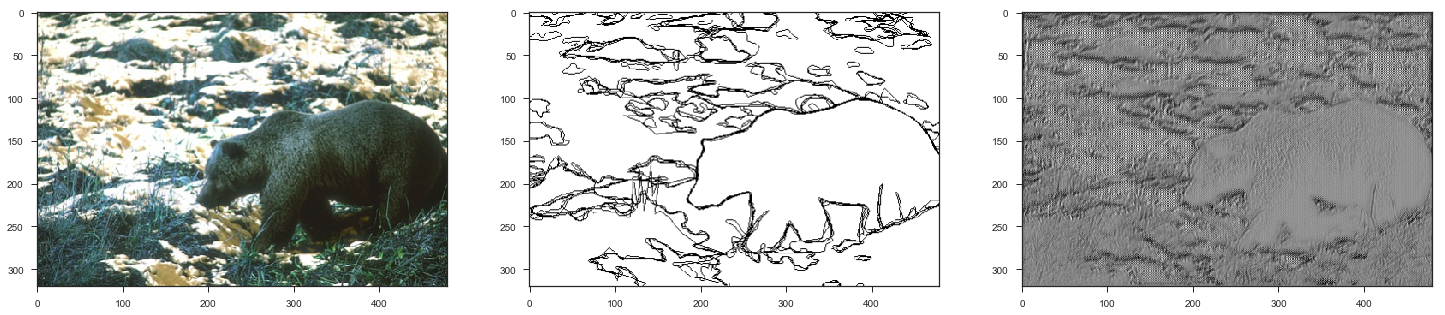

In [119]:
y_pred_2 = model2.predict(X_train[2].reshape((-1,320,480,3)))[-1]
y_pred_2 = y_pred_2.reshape((320, 480))
np.savetxt(RESULT_PATH + '/sample_pred_HED.csv', y_pred_2, fmt='%3f')
# y_pred_2[y_pred_2 >= 0.5] = 1
# y_pred_2[y_pred_2 <= 0.4] = 0
plt.figure(figsize=(25,16))
plt.subplot(1,3,1)
plt.imshow(X_train[2], cmap='binary')
plt.subplot(1,3,2)
plt.imshow(y_train[2].reshape((320,480)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred_2, cmap='binary')
plt.show()